### Анализ A/A/B-эксперимента
Предстоит проанализировать результаты A/A/B-эксперимента, суть которого в том, что дизайнеры захотели поменять шрифты во всём приложении и необходимо вынести решение по этому предложению

В данных 3 группы, 2 контрольные и 1 эксперементальная, необходимо проверить данные в группах и проверить данные на пригодность к анализу

План работы - проверить данные, очистить от случайно попавших данных, сопоставить группы и дать рекомендации менеджерам

Цель работы - обосновать результаты эксперемента и сообщить вердикт по результатам сравнения контрольных и экспертной группы

###  Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
import math as mth
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<b>При выгузке разделили столбцы, заметим что пропусков нет, однако не очень понятные названия столбцов и не читаемые форматы даты

### Подготовим данные

In [5]:
df = df.rename(
 columns={
'EventName': 'event_name',
'DeviceIDHash': 'userId',
'EventTimestamp': 'dt',
'ExpId': 'group',
 }
)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   userId      244126 non-null  int64 
 2   dt          244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
df['dt'] = pd.to_datetime(df['dt'], unit='s')

In [8]:
df['data'] = pd.to_datetime(df['dt']).dt.floor('D')

In [9]:
df

,event_name,userId,dt,group,data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [10]:
df.duplicated().sum()

413

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   userId      243713 non-null  int64         
 2   dt          243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   data        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [13]:
df.groupby('userId').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

<b>Были переменованы столбцы на event_name,	userId,	dt,	group, а также добавлен столбец	data. Удалили дубликаты и выполнили проверку на пересечение пользователей в группах, пересечений не обнаружено.

### Изучим и проверим данные

Найдем сколько всего событий в логе

In [14]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего 5  событий

Найдем сколько всего пользователей в логе

In [15]:
df['userId'].value_counts()

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
395376432319166724        1
404128138074395619        1
6936517579657223951       1
5138854326043201424       1
3954096321632083010       1
Name: userId, Length: 7551, dtype: int64

In [16]:
df['userId'].nunique()

7551

Таким образом в таблице 7551 уникальных пользователей

Найдем сколько в среднем событий приходится на пользователя

In [17]:
mean_df = df.groupby('userId')['event_name'].agg('count')
mean_df.describe() 

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

In [18]:
df.groupby('userId')['event_name'].agg('count').median()

20.0

Проверим данными за какой период мы располагаем

In [19]:
print(df['dt'].min())

2019-07-25 04:43:36


In [20]:
print(df['dt'].max())

2019-08-07 21:15:17


In [21]:
df['data'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: data, dtype: int64

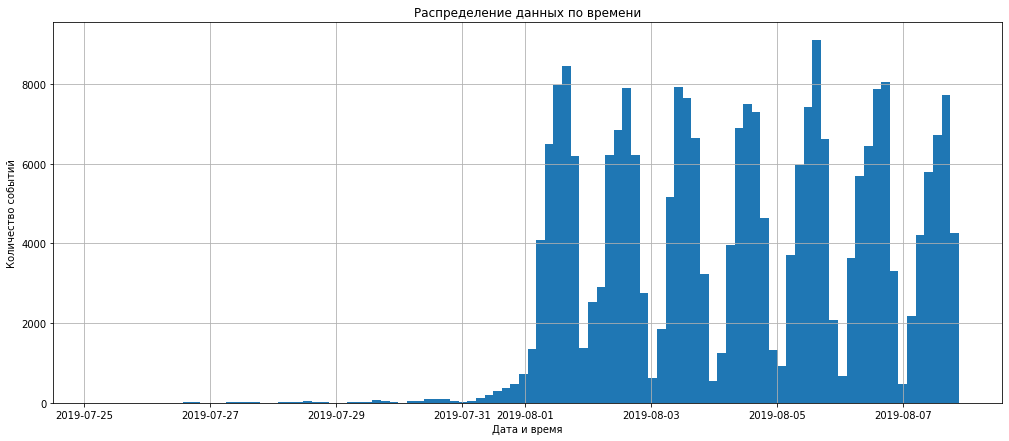

In [22]:
plt.figure(figsize=(17, 7))
df['dt'].hist(bins=100)
plt.title('Распределение данных по времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.show()

отсеим данные ранее 1 августа 2019 года, так как эти данные сильно отличаются от остальных (с первого числа ежедневно данных более 30000)

In [23]:
df_good = df.query('dt >= "2019-08-01 00:00:00"')

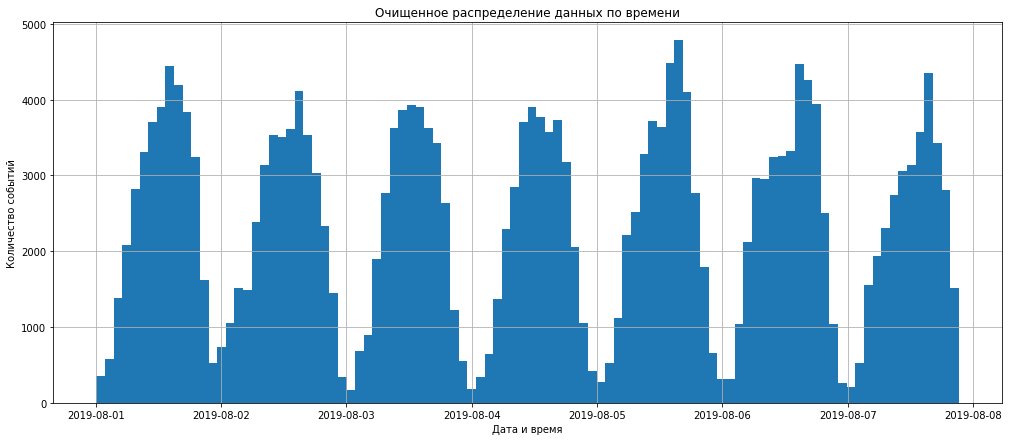

In [24]:
plt.figure(figsize=(17, 7))
df_good['dt'].hist(bins=100)
plt.title('Очищенное распределение данных по времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.show()

In [25]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   userId      240887 non-null  int64         
 2   dt          240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   data        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [26]:
df_good['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [27]:
df_good['userId'].nunique()

7534

In [28]:
df_good.groupby('userId')['event_name'].agg('count').median()

19.0

Проверим много ли событий и пользователей отсеялось

In [29]:
df['event_name'].count() - df_good['event_name'].count()

2826

In [30]:
(df['event_name'].count() - df_good['event_name'].count()) / df['event_name'].count() *100

1.159560630741897

In [31]:
df['event_name'].value_counts() - df_good['event_name'].value_counts()

MainScreenAppear           1773
OffersScreenAppear          475
CartScreenAppear            365
PaymentScreenSuccessful     200
Tutorial                     13
Name: event_name, dtype: int64

In [32]:
df['userId'].nunique() - df_good['userId'].nunique()

17

In [33]:
(df['userId'].nunique() - df_good['userId'].nunique()) / df['userId'].nunique() *100

0.22513574361011784

<b>Таким образом из данных отсеялось 2826 события (на 1,16%) и 17 уникальных польхователей (на 0,23%)

Проверим, есть ли пользователи из всех трёх экспериментальных групп.

In [64]:
df_good.groupby('group').agg({'userId': ['count', 'nunique']})

userId        
       count nunique
group               
246    79302    2484
247    77022    2513
248    84563    2537

### Изучим воронку событий

Посмотрим, какие события есть в логах и как часто они встречаются

In [35]:
df_good['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий

In [36]:
event = df_good.groupby('event_name').agg({'userId': 'nunique'})
event.sort_values(by='userId', ascending=False) 

,userId
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [37]:
event_us = event / df_good['userId'].nunique()
event_us.sort_values(by='userId', ascending=False) 

,userId
event_name,
MainScreenAppear,0.984736
OffersScreenAppear,0.609636
CartScreenAppear,0.495620
PaymentScreenSuccessful,0.469737
Tutorial,0.111495


Предположим, в каком порядке происходят события

<b> Воронка выглядит следующим образом:
1. Появление главного экрана 
2. Появление экрана предложений
3. Появление экрана корзины
4. Экран успешно завершенной покупки

есть страница "Руководство", но, по всей видимости, она не входит в воронку, а используется лишь некоторыми пользователями в качестве помощи, поэтому уберем данный пункт из дальнейшего анализа

In [38]:
funnel = event.drop(labels = ['Tutorial'],axis = 0)
funnel = funnel.sort_values(by='userId', ascending=False)
display(funnel)

,userId
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки 

In [39]:
funnel['percent'] = funnel['userId'] / funnel['userId'].shift(1).fillna(7419/1)
funnel['percent'] = funnel['percent'].round(4) *100
funnel

,userId,percent
event_name,,
MainScreenAppear,7419,100.00
OffersScreenAppear,4593,61.91
CartScreenAppear,3734,81.30
PaymentScreenSuccessful,3539,94.78


In [40]:
profel = df_good.pivot_table(
    index='userId', 
    columns='event_name', 
    values='dt',
    aggfunc='min')
profel = profel.drop(labels = ['Tutorial'],axis = 1)
profel

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
userId,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT


In [41]:
level_1 = ~profel['MainScreenAppear'].isna() 
level_2 = level_1 & (profel['OffersScreenAppear'] > profel['MainScreenAppear']) 
level_3 = level_2 & (profel['CartScreenAppear'] > profel['OffersScreenAppear']) 
level_4 = level_3 & (profel['PaymentScreenSuccessful'] > profel['CartScreenAppear'])

In [42]:
count_level_1 = profel[level_1].shape[0]
count_level_2 = profel[level_2].shape[0]
count_level_3 = profel[level_3].shape[0]
count_level_4 = profel[level_4].shape[0]

In [43]:
sob = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 'count': [count_level_1, count_level_2, count_level_3, count_level_4]}
sob_fin = pd.DataFrame(sob) 
sob_fin['%'] = sob_fin['count'] / sob_fin['count'].shift(1).fillna(7419/1)
sob_fin['%'] = sob_fin['%'].round(4) *100
sob_fin

,event_name,count,%
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4201,56.62
2,CartScreenAppear,1767,42.06
3,PaymentScreenSuccessful,454,25.69


In [44]:
gr_profel = df_good.pivot_table(
    index=['userId', 'group'],
    columns='event_name', 
    values='dt',
    aggfunc='min')
gr_profel = gr_profel.drop(labels = ['Tutorial'],axis = 1)
gr_profel

,event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
userId,group,,,,
6888746892508752,246,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,247,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,246,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,248,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,247,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...,...
9217594193087726423,246,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
9219463515465815368,248,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
9220879493065341500,246,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT


In [45]:
g_246 = gr_profel.query('group == 246')
g_247 = gr_profel.query('group == 247')
g_248 = gr_profel.query('group == 248')

In [46]:
g_246lvl_1 = ~g_246['MainScreenAppear'].isna() 
g_246lvl_2 = g_246lvl_1 & (g_246['OffersScreenAppear'] > g_246['MainScreenAppear']) 
g_246lvl_3 = g_246lvl_2 & (g_246['CartScreenAppear'] > g_246['OffersScreenAppear']) 
g_246lvl_4 = g_246lvl_3 & (g_246['PaymentScreenSuccessful'] > g_246['CartScreenAppear'])

g_247lvl_1 = ~g_247['MainScreenAppear'].isna() 
g_247lvl_2 = g_247lvl_1 & (g_247['OffersScreenAppear'] > g_247['MainScreenAppear']) 
g_247lvl_3 = g_247lvl_2 & (g_247['CartScreenAppear'] > g_247['OffersScreenAppear']) 
g_247lvl_4 = g_247lvl_3 & (g_247['PaymentScreenSuccessful'] > g_247['CartScreenAppear'])

g_248lvl_1 = ~g_248['MainScreenAppear'].isna() 
g_248lvl_2 = g_248lvl_1 & (g_248['OffersScreenAppear'] > g_248['MainScreenAppear']) 
g_248lvl_3 = g_248lvl_2 & (g_248['CartScreenAppear'] > g_248['OffersScreenAppear']) 
g_248lvl_4 = g_248lvl_3 & (g_248['PaymentScreenSuccessful'] > g_248['CartScreenAppear'])

In [47]:
g_246count_lvl_1 = g_246[g_246lvl_1].shape[0]
g_246count_lvl_2 = g_246[g_246lvl_2].shape[0]
g_246count_lvl_3 = g_246[g_246lvl_3].shape[0]
g_246count_lvl_4 = g_246[g_246lvl_4].shape[0]

g_247count_lvl_1 = g_247[g_247lvl_1].shape[0]
g_247count_lvl_2 = g_247[g_247lvl_2].shape[0]
g_247count_lvl_3 = g_247[g_247lvl_3].shape[0]
g_247count_lvl_4 = g_247[g_247lvl_4].shape[0]

g_248count_lvl_1 = g_248[g_248lvl_1].shape[0]
g_248count_lvl_2 = g_248[g_248lvl_2].shape[0]
g_248count_lvl_3 = g_248[g_248lvl_3].shape[0]
g_248count_lvl_4 = g_248[g_248lvl_4].shape[0]

In [48]:
g_246sob = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 'count': [g_246count_lvl_1, g_246count_lvl_2, g_246count_lvl_3, g_246count_lvl_4]}
g_246sob_fin = pd.DataFrame(g_246sob) 
g_246sob_fin['%'] = g_246sob_fin['count'] / g_246sob_fin['count'].shift(1).fillna(7419/1)
g_246sob_fin['%'] = g_246sob_fin['%'].round(4) *100
g_246sob_fin

,event_name,count,%
0,MainScreenAppear,2450,33.02
1,OffersScreenAppear,1411,57.59
2,CartScreenAppear,584,41.39
3,PaymentScreenSuccessful,145,24.83


In [49]:
g_247sob = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 'count': [g_247count_lvl_1, g_247count_lvl_2, g_247count_lvl_3, g_247count_lvl_4]}
g_247sob_fin = pd.DataFrame(g_247sob) 
g_247sob_fin['%'] = g_247sob_fin['count'] / g_247sob_fin['count'].shift(1).fillna(7419/1)
g_247sob_fin['%'] = g_247sob_fin['%'].round(4) *100
g_247sob_fin

,event_name,count,%
0,MainScreenAppear,2476,33.37
1,OffersScreenAppear,1379,55.69
2,CartScreenAppear,600,43.51
3,PaymentScreenSuccessful,144,24.00


In [50]:
g_248sob = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 'count': [g_248count_lvl_1, g_248count_lvl_2, g_248count_lvl_3, g_248count_lvl_4]}
g_248sob_fin = pd.DataFrame(g_248sob) 
g_248sob_fin['%'] = g_248sob_fin['count'] / g_248sob_fin['count'].shift(1).fillna(7419/1)
g_248sob_fin['%'] = g_248sob_fin['%'].round(4) *100
g_248sob_fin

,event_name,count,%
0,MainScreenAppear,2493,33.60
1,OffersScreenAppear,1411,56.60
2,CartScreenAppear,583,41.32
3,PaymentScreenSuccessful,165,28.30


<b> Таким образом, заметим что если смотреть по количеству уникальных пользователей на каждом шаге воронке то конверсия показывает довольно хорошие значения, однако если проследить за пользователями которые пошагово переходили от пускта к пункту, то конверсия резко падает, разберемся в чем причина далее

На каком шаге теряете больше всего пользователей?

<b> При переходе на второй этап (OffersScreenAppear) теряется больше всего пользователь в абсолютном выражении (больше тысячи уникальных пользователей), но на последнем этапе (PaymentScreenSuccessful) теряется больше всего пользователей в процентном выражении (порядка 74%)

Какая доля пользователей доходит от первого события до оплаты?

In [51]:
sob_fin['count'] / sob_fin['count'].shift(3)*100

0         NaN
1         NaN
2         NaN
3    6.119423
Name: count, dtype: float64

<b> Всего 6,12% пользоватеоей доходят до оплаты

### Изучим результаты эксперимента

Сколько пользователей в каждой экспериментальной группе?

In [52]:
df_good.groupby('group').agg({'userId': ['count', 'nunique']})

userId        
       count nunique
group               
246    79302    2484
247    77022    2513
248    84563    2537

In [53]:
df_good_fin = df_good[df_good.event_name != 'Tutorial']

In [54]:
df_good_fin.groupby('group').agg({'userId': ['count', 'nunique']})

userId        
       count nunique
group               
246    78985    2483
247    76684    2512
248    84213    2535

In [55]:
print(2483/2512)
print(2483/2535)
print(2512/2535)

0.9884554140127388
0.9794871794871794
0.9909270216962525


In [56]:
g_247sob_fin.loc[0, 'count'] 

2476

<b>Были отобраны уникальные пользователи которые попали в обозначенную нами воронку, заметим что в группах А/А различия в количестве участников чуть больше 1%, а разница 247 и 248 групп составляет 2%

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Далее проверим статистическую значимость различий пропорций между группами. Нулевая гипотеза: различий в пропорции между группами нет. Альтернативная гипотеза: различия в пропорции между группами есть.

In [57]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([g_246sob_fin.loc[3, 'count'], g_247sob_fin.loc[3, 'count']])
trials = np.array([g_246sob_fin.loc[0, 'count'], g_247sob_fin.loc[0, 'count']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.8783092501812453
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [58]:
alpha = .05 # критический уровень статистической значимости

def substitute (successes, trials):

# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
    
substitute(successes = np.array([g_246sob_fin.loc[0, 'count'], g_247sob_fin.loc[0, 'count']]), trials = np.array([2483, 2512]))
substitute(successes = np.array([g_246sob_fin.loc[1, 'count'], g_247sob_fin.loc[1, 'count']]), trials = np.array([g_246sob_fin.loc[0, 'count'], g_247sob_fin.loc[0, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[2, 'count'], g_247sob_fin.loc[2, 'count']]), trials = np.array([g_246sob_fin.loc[1, 'count'], g_247sob_fin.loc[1, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[3, 'count'], g_247sob_fin.loc[3, 'count']]), trials = np.array([g_246sob_fin.loc[2, 'count'], g_247sob_fin.loc[2, 'count']]))

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.1791392160319234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2571602924470018
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7399516568824782
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Были проверены все переходы пользователей на следующий этап, нет оснований считать доли в группах разными

Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [59]:
alpha = .05 # критический уровень статистической значимости

def substitute (successes, trials):

# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
print('сравниваем 246 и 248 группы')     
substitute(successes = np.array([g_246sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]), trials = np.array([2483, 2535]))
substitute(successes = np.array([g_246sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]), trials = np.array([g_246sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]), trials = np.array([g_246sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[3, 'count'], g_248sob_fin.loc[3, 'count']]), trials = np.array([g_246sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]))

print('-------------------------------------------------------------------')
print('сравниваем 247 и 248 группы') 
substitute(successes = np.array([g_247sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]), trials = np.array([2512, 2535]))
substitute(successes = np.array([g_247sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]), trials = np.array([g_247sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]))
substitute(successes = np.array([g_247sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]), trials = np.array([g_247sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]))
substitute(successes = np.array([g_247sob_fin.loc[3, 'count'], g_248sob_fin.loc[3, 'count']]), trials = np.array([g_247sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]))

print('-------------------------------------------------------------------')
print('сравниваем объединенные 246 и 247 с 248 группой') 
substitute(successes = np.array([g_246sob_fin.loc[0, 'count']+g_247sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]), trials = np.array([2483+2512, 2535]))
substitute(successes = np.array([g_246sob_fin.loc[1, 'count']+g_247sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]), trials = np.array([g_246sob_fin.loc[0, 'count']+g_247sob_fin.loc[0, 'count'], g_248sob_fin.loc[0, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[2, 'count']+g_247sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]), trials = np.array([g_246sob_fin.loc[1, 'count']+g_247sob_fin.loc[1, 'count'], g_248sob_fin.loc[1, 'count']]))
substitute(successes = np.array([g_246sob_fin.loc[3, 'count']+g_247sob_fin.loc[3, 'count'], g_248sob_fin.loc[3, 'count']]), trials = np.array([g_246sob_fin.loc[2, 'count']+g_247sob_fin.loc[2, 'count'], g_248sob_fin.loc[2, 'count']]))

print('-------------------------------------------------------------------')

сравниваем 246 и 248 группы
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.48049838808343814
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9695085280919828
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.17922330576112433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------------------------------------------------------------
сравниваем 247 и 248 группы
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5208915431808141
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.24154783250462764
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.09219350245330471
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 

данные можно считать пригодными, и тест в целом успешным, так как по всем соотношениям получены пригодные данные

Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При увеличении уровня значимости возрастает возможность получения ошибки, что в принципе и происходит при ее уровне в 0,1 (каждый 4 результат показывает ошибку из 12 тестов), было решено применить уровень значимости 0,05 так как он показал вполне приемлемые показатели и является стандартным


In [60]:
g_246sob_fin.loc[:, 'count']

0    2450
1    1411
2     584
3     145
Name: count, dtype: int64

In [61]:
g_247sob_fin.loc[:, 'count']

0    2476
1    1379
2     600
3     144
Name: count, dtype: int64

In [62]:
g_248sob_fin.loc[:, 'count']

0    2493
1    1411
2     583
3     165
Name: count, dtype: int64

In [63]:
#Проверим гипотезу о равенстве среднего количества пользователей в каждой паре датасетов. 

sample_A = [2450, 1411, 584, 145]
sample_B = [2476, 1379, 600, 144]
sample_C = [2493, 1411, 583, 165]

alpha = 0.05  # критический уровень статистической значимости

results_AB = st.ttest_ind(sample_A, sample_B)

results_BC = st.ttest_ind(sample_B, sample_C)

results_AC = st.ttest_ind(sample_A, sample_C)

bonferroni_alpha = 1 - (1 - alpha)**(1/3)  # произведено три сравнения

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп А и C: ', results_AC.pvalue)

if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    )

p-значение для сравнения групп А и B:  0.9976065642041096
p-значение для сравнения групп B и C:  0.9859897626714496
p-значение для сравнения групп А и C:  0.9835629311044438
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B
Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C


Наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами.

### Вывод

В результате выполненного анализа данных мы приходим к следующим выводам:

- При выгузке разделили столбцы, заметим что пропусков нет, однако не очень понятные названия столбцов и не читаемые форматы даты

- Были переменованы столбцы на event_name, userId, dt, group, а также добавлен столбец data. Удалили дубликаты и выполнили проверку на пересечение пользователей в группах, пересечений не обнаружено

- Всего в данных 5 событий и 7551 уникальных пользователей. В среднем на каждого пользователя приходится по 20 событий, однако после проверки данных на распределение во времени и после обрезания временных рамок количество уникальных пользователей сократилось до 7534 и до 19 событий на одного пользователя

- Воронка выглядит следующим образом:

1. Появление главного экрана
2. Появление экрана предложений
3. Появление экрана корзины
4. Экран успешно завершенной покупки
есть страница "Руководство", но, по всей видимости, она не входит в воронку, а используется лишь некоторыми пользователями в качестве помощи, поэтому уберем данный пункт из дальнейшего анализа

Заметим что если смотреть по количеству уникальных пользователей на каждом шаге воронке то конверсия показывает довольно хорошие значения, однако если проследить за пользователями которые пошагово переходили от пускта к пункту, то конверсия резко падает.

Больше всего пользователей теряется при переходе на второй этап (OffersScreenAppear) в абсолютном выражении, но на последнем этапе теряется больше всего пользователей в процентном выражении (порядка 74%) и всего 6,12% пользоватеоей доходят до оплаты

- Были отобраны уникальные пользователи которые попали в обозначенную нами воронку, заметим что в группах А/А различия в количестве участников чуть больше 1%, а разница 247 и 248 групп составляет 2%

- Данные можно считать пригодными, и тест в целом успешным, так как по всем соотношениям данные в группах являются равными. 



В целом по результату теста можно сказать, что дизайнерам стоит поменять все таки шрифт так как конверсия поднялась до 28% в отличии от контрольных групп, где этот показатель находился на уровне 25%